# Experiment 4.5: End-to-end clipping

The aim of this experiment is to test the model end-to-end, feeding it with a dataset of medium-length videos (4 - 10 minutes) under ActivityNet categories.

**The notebook from experiment 4.1 must be executed before this notebook**

## 1. Enviornment

In the following cell, change assign WD the path to the BMT-Clipping repository. 
Additionally, assign the path to your environments directory (e.g. where conda stores all directories) to the ENVS_PATH variable.

In [1]:
# Working directory (it must be the repository's root directory)
WD = '/home/A01630791/BMT-Clipping'
%cd $WD

# Environments directory (e.g. anaconda3/envs)
ENVS_PATH = '/home/A01630791/anaconda3/envs'

/home/A01630791/BMT-Clipping


**Optional**  
Uncomment and run the following cell if you haven't configured the Python environment in experiment 4.1

Run directly in terminal if the notebook throws errors.

In [7]:
"""
# Environment
## feature extraction (run directly in terminal if the notebook can't execute)
!conda env create -f ./submodules/video_features/conda_env_i3d.yml
!conda env create -f ./submodules/video_features/conda_env_vggish.yml
## captioning model (run directly in terminal if the notebook can't execute)
!conda env create -f ./conda_env.yml
## spacy language model (use the path to your 'bmt' environment instead)
!$ENVS_PATH/bmt/bin/python -m spacy download en


# (Optional) Install additional libraries in environment (run directly in terminal if the notebook can't execute)
!conda install pytube
!conda install numpy
!conda install matplotlib
"""

"\n# Environment\n## feature extraction (run directly in terminal if the notebook can't execute)\n!conda env create -f ./submodules/video_features/conda_env_i3d.yml\n!conda env create -f ./submodules/video_features/conda_env_vggish.yml\n## captioning model (run directly in terminal if the notebook can't execute)\n!conda env create -f ./conda_env.yml\n## spacy language model (use the path to your 'bmt' environment instead)\n!$ENVS_PATH/bmt/bin/python -m spacy download en\n\n\n# (Optional) Install additional libraries in environment (run directly in terminal if the notebook can't execute)\n!conda install pytube\n!conda install numpy\n!conda install matplotlib\n"

**BMT imports**

In [2]:
import os
from pathlib import Path
import sys
sys.path.append(WD)
from sample.single_video_prediction import get_video_duration

**Module imports**

In [3]:
from clipping_modules.filtering import FilteringModule
from clipping_modules.clipping import ClippingModule

**Other imports**

In [4]:
import json, re, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytube import YouTube

## 2. Importing the dataset

A copy of LABC is provided in our repository in `data/long_activitynet_categories.csv`, so there is no need to download it. The url is https://github.com/oscarmires/BMT-Clipping/blob/master/data/long_activitynet_categories.csv

In [5]:
# Replace the value of the following variable with the path to the dataset in your fs.
MABC_PATH = f'{WD}/data/mabc.csv'
MABC_PATH

# Open the file as a Pandas DF
mabc_df = pd.read_csv(MABC_PATH, index_col=0)
mabc_df.head()

,url,duration,category
id,,,
HzSkdZzqvT8,https://www.youtube.com/watch?v=HzSkdZzqvT8,253,Archery
qy6dlGpC3Ns,https://www.youtube.com/watch?v=qy6dlGpC3Ns,361,Ballet
v4hRS2XF5WA,https://www.youtube.com/watch?v=v4hRS2XF5WA,487,Basketball
alF-r5DlERY,https://www.youtube.com/watch?v=alF-r5DlERY,300,Bathing dog
69cpDT0rJNM,https://www.youtube.com/watch?v=69cpDT0rJNM,494,Clean and jerk


In [6]:
mabc_df.duration.sum() / 60 / 60

1.0925

In [7]:
# Optional: sort by duration
mabc_df.sort_values(by='duration', inplace=True)

### 2.1 YouTube Downloads
The following cell downloads from YouTube all the videos listed in LABC. Create a directory to store the videos. A path to this directory must be assigned to the variable `LABC_VIDEOS_PATH`.

In [8]:
# Assign your path to the next variable
MABC_VIDEOS_PATH = '/home/A01630791/bmt_clipping_experiments/MABC_videos'

video_count = 0
mabc_rows = mabc_df.shape[0]

dir_list = os.listdir(MABC_VIDEOS_PATH)

In [9]:
for video_id, sample in mabc_df.iterrows():
    video_count += 1
    
    if f'{video_id}.mp4' in dir_list:
        print(f'"{video_id}.mp4" already in directory.')
        continue
    
    try: 
        print(f'Downloading {video_count}/{mabc_rows}...')
        
        yt = YouTube(sample['url']) 
        filename = f'{video_id}.mp4'
        stream = yt.streams.get_highest_resolution()
        stream.download(output_path=MABC_VIDEOS_PATH, filename=filename)
    except: 
        print("Error: can't instantiate YouTube object.") 
        exec_md['not_found_videos'].append(video_id)
        os.remove(f'{MABC_VIDEOS_PATH}/{filename}')
    # Optional break to limit number of videos:
    if video_count >= 25:
        break
        
print(f'Downloaded {video_count}/{mabc_rows} videos.')

"HzSkdZzqvT8.mp4" already in directory.
"alF-r5DlERY.mp4" already in directory.
"KI8WzyzQbGE.mp4" already in directory.
"0kRtLFXIKpM.mp4" already in directory.
"qy6dlGpC3Ns.mp4" already in directory.
"A_aFIpDqRPw.mp4" already in directory.
"aZPAKeZe_Vc.mp4" already in directory.
"v4hRS2XF5WA.mp4" already in directory.
"69cpDT0rJNM.mp4" already in directory.
"e4nrthWzflw.mp4" already in directory.
Downloaded 10/10 videos.


In [ ]:
"""
LABC_VIDEOS_PATH = '/home/A01630791/bmt_clipping_experiments/Output_4_3/ft_clips'


df = pd.DataFrame(os.listdir(LABC_VIDEOS_PATH))
df['clip_id'] = [(int) (re.findall("(?<=&).*?(?=\.)", row[0])[0]) for index, row in df.iterrows()]

df.sort_values(by='clip_id')
"""

## 3. Execution


### 3.1 Preparation

Assign the path to a directory where you would like to create the output file. We name this file `4_5_bmt_captions_ft.json` for the fixed-window clipping and `4_5_bmt_captions_ps.json` for the pyscene clipping.

In [10]:
OUTPUT_PATH = '/home/A01630791/bmt_clipping_experiments/Output_4_5'

In [11]:
with open(f'{OUTPUT_PATH}/4_5_bmt_captions_ft.json', "w") as f:
  f.write("[]")

In [12]:
with open(f'{OUTPUT_PATH}/4_5_bmt_captions_ps.json', "w") as f:
  f.write("[]")

### 3.3 BMT Installation (optional)

Uncomment and run the following cell if you haven't installed the BMT model in experiment 4.1

Run directly in terminal if the notebook throws errors.

In [ ]:
"""
# Download BMT Checkpoints

!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/glove.840B.300d.zip
!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/best_cap_model.pt
!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/best_prop_model.pt
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt

!mkdir .vector_cache
!mv glove.840B.300d.zip ./.vector_cache/
!mv best_cap_model.pt ./sample/
!mv best_prop_model.pt ./sample/
!mv vggish_model.ckpt ./submodules/video_features/models/vggish/checkpoints/
"""

### 3.4 BMT Function
The following cell generates I3D features, Vggish features, event proposals and event captions for each of the videos in `labc_df`. It wraps all this steps in one function used later for each clip.

In [13]:
def run_bmt(input_path, output_path, video_id, clip_id):
    # captioning parameters
    MAX_PROP_PER_VIDEO = 100
    NMS_TIOU_THRESHOLD = 0.4

    # checkpoint paths
    PROPOSAL_CKPT = f'{WD}/sample/best_prop_model.pt'
    CAPTIONING_CKPT = f'{WD}/sample/best_cap_model.pt'

    # Extract visual and audio features

    ## Prepare complementary paths
    MY_VIDEO_PATH = input_path

    VIDEO_DURATION = get_video_duration(MY_VIDEO_PATH)

    FEATURES_CACHE_PATH = f'{WD}/tmp/'
    FEATURES_PATH_STUB = os.path.join(FEATURES_CACHE_PATH, Path(MY_VIDEO_PATH).stem)
    FEATURE_PATH_VGGISH = f'{FEATURES_PATH_STUB}_vggish.npy'
    FEATURE_PATH_RGB = f'{FEATURES_PATH_STUB}_rgb.npy'
    FEATURE_PATH_FLOW = f'{FEATURES_PATH_STUB}_flow.npy'

    ## Extract I3D features
    print('Extracting I3D features.')
    !cd ./submodules/video_features && $ENVS_PATH/i3d/bin/python main.py \
      --feature_type i3d \
      --on_extraction save_numpy \
      --device_ids 0 \
      --extraction_fps 25 \
      --video_paths $MY_VIDEO_PATH \
      --output_path $FEATURES_CACHE_PATH

    print('Extracting VGGish features.')
    ## Extract VGGish features (audio)
    !cd ./submodules/video_features && $ENVS_PATH/vggish/bin/python main.py \
      --feature_type vggish \
      --on_extraction save_numpy \
      --device_ids 0 \
      --video_paths $MY_VIDEO_PATH \
      --output_path $FEATURES_CACHE_PATH

    # Step 3: Captioning
    print('Generating caption...')

    try:
        ## Run single video prediction
        !$ENVS_PATH/bmt/bin/python ./sample/single_video_prediction.py \
          --prop_generator_model_path $PROPOSAL_CKPT \
          --pretrained_cap_model_path $CAPTIONING_CKPT \
          --vggish_features_path $FEATURE_PATH_VGGISH \
          --rgb_features_path $FEATURE_PATH_RGB \
          --flow_features_path $FEATURE_PATH_FLOW \
          --duration_in_secs $VIDEO_DURATION \
          --device_id 0 \
          --max_prop_per_vid $MAX_PROP_PER_VIDEO \
          --nms_tiou_thresh $NMS_TIOU_THRESHOLD \
          --video_id $video_id \
          --clip_id $clip_id \
          --output_path $output_path
    except AssertionError:
        print('Exceeded MAX_PROP_PER_VIDEO')
        exec_md['too_many_features'].append(video_id)

    print('BMT Execution completed.') 

### 3.4 Fixed-time clipping
For this first test, we will be using a window of 2 minutes for performing the fixed-time clipping. Assign the variable `FT_CLIPS_DIR` the path to the directory where you wish to store the clips temporarily. 

In [39]:
FT_CLIPS_DIR = f'{OUTPUT_PATH}/ft_clips' # Your path here
%ls $FT_CLIPS_DIR

0kRtLFXIKpM@0.mp4    HzSkdZzqvT8@120.mp4  e4nrthWzflw@120.mp4
0kRtLFXIKpM@120.mp4  HzSkdZzqvT8@240.mp4  e4nrthWzflw@240.mp4
0kRtLFXIKpM@240.mp4  KI8WzyzQbGE@0.mp4    e4nrthWzflw@360.mp4
69cpDT0rJNM@0.mp4    KI8WzyzQbGE@120.mp4  e4nrthWzflw@480.mp4
69cpDT0rJNM@120.mp4  KI8WzyzQbGE@240.mp4  qy6dlGpC3Ns@0.mp4
69cpDT0rJNM@240.mp4  aZPAKeZe_Vc@0.mp4    qy6dlGpC3Ns@120.mp4
69cpDT0rJNM@360.mp4  aZPAKeZe_Vc@120.mp4  qy6dlGpC3Ns@240.mp4
69cpDT0rJNM@480.mp4  aZPAKeZe_Vc@240.mp4  qy6dlGpC3Ns@360.mp4
A_aFIpDqRPw@0.mp4    aZPAKeZe_Vc@360.mp4  v4hRS2XF5WA@0.mp4
A_aFIpDqRPw@120.mp4  alF-r5DlERY@0.mp4    v4hRS2XF5WA@120.mp4
A_aFIpDqRPw@240.mp4  alF-r5DlERY@120.mp4  v4hRS2XF5WA@240.mp4
A_aFIpDqRPw@360.mp4  alF-r5DlERY@240.mp4  v4hRS2XF5WA@360.mp4
HzSkdZzqvT8@0.mp4    e4nrthWzflw@0.mp4    v4hRS2XF5WA@480.mp4


The next cell instantiates the clipping module.

In [40]:
cm = ClippingModule(
    path_to_video_out=FT_CLIPS_DIR, 
    window=120, 
    technique='fixed'
)

We then obtain clips from all videos:

In [19]:
videos_list = os.listdir(MABC_VIDEOS_PATH)

for video in videos_list[:]:
    if video[0] != '.': # ignore hidden files
        cm.get_clips(f'{MABC_VIDEOS_PATH}/{video}', video[:11])

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join

We need to create a DataFrame to keep track of all filenames, video IDs and clip IDs.

In [41]:
# Initialize
df = pd.DataFrame(os.listdir(FT_CLIPS_DIR), columns=['filename'])

# Clean
df.drop(df[df['filename'].str.startswith('.')].index, inplace=True)

# Obtain clip id
df['clip_id'] = [(int) (re.findall("(?<=@).*?(?=\.)", row['filename'])[0]) for index, row in df.iterrows()]

# Obtain video id
df['video_id'] = [(re.findall(".*?(?=\@)", row['filename'])[0]) for index, row in df.iterrows()]

df.head()

,filename,clip_id,video_id
0,HzSkdZzqvT8@0.mp4,0,HzSkdZzqvT8
1,HzSkdZzqvT8@120.mp4,120,HzSkdZzqvT8
2,HzSkdZzqvT8@240.mp4,240,HzSkdZzqvT8
3,alF-r5DlERY@0.mp4,0,alF-r5DlERY
4,alF-r5DlERY@120.mp4,120,alF-r5DlERY


In [42]:
# optional: select fewer videos if time limitations
limited_sample_video_ids = df.video_id.unique()[:10]
limited_sample_video_ids

limited_df = df[df['video_id'].isin(limited_sample_video_ids)]
limited_df.video_id.unique()

array(['HzSkdZzqvT8', 'alF-r5DlERY', 'KI8WzyzQbGE', '0kRtLFXIKpM',
       'qy6dlGpC3Ns', 'A_aFIpDqRPw', 'aZPAKeZe_Vc', 'v4hRS2XF5WA',
       '69cpDT0rJNM', 'e4nrthWzflw'], dtype=object)

The next cell will execute the BMT model to generate captions for each clip.

In [44]:
# execution metadata
exec_md = {
    'current_sample_num': 1,
    'total_samples': limited_df.shape[0],
}


for index, sample in limited_df.iterrows():
    
    run_bmt(
        input_path=f'{FT_CLIPS_DIR}/{sample.filename}', 
        output_path=f'{OUTPUT_PATH}/4_5_bmt_captions_ft.json', 
        video_id=sample.video_id, 
        clip_id=sample.clip_id
    )
    

    curr_sample = exec_md['current_sample_num']
    exec_md['current_sample_num'] += 1
    total_samples = exec_md['total_samples']
    print(f'\n ***** Processed {curr_sample}/{total_samples} samples. *****\n')


Video Duration: 120.034
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|████████████████████████████████████████████| 1/1 [01:49<00:00, 109.59s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.66s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  124
***** S *****:  46
***** S *****:  46
{'video_id': 'HzSkdZzqvT8', 'clip_id': '0', 'captions': [{'start': 5.4, 'end': 28.9, 'sentence': 'The man is then shown a

{'video_id': 'alF-r5DlERY', 'clip_id': '240', 'captions': [{'start': 50.5, 'end': 61.7, 'sentence': 'The credits of the video are shown'}, {'start': 3.4, 'end': 56.1, 'sentence': 'He then uses a towel to wash his hands with his hands and continues to wash his hands'}, {'start': 32.5, 'end': 52.7, 'sentence': 'The man then washes his face with the towel and washes his hands with the dog'}], 'duration': 61.696}
BMT Execution completed.

 ***** Processed 6/39 samples. *****

Video Duration: 120.001
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|████████████████████████████████████████████| 1/1 [02:00<00:00, 120.44s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|██████████████████

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.23s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  109
***** S *****:  40
***** S *****:  40
{'video_id': '0kRtLFXIKpM', 'clip_id': '240', 'captions': [{'start': 0.0, 'end': 18.5, 'sentence': 'She then puts polish on her shoe and puts a shoe on'}, {'start': 15.7, 'end': 64.1, 'sentence': 'The person then puts a shoe on and puts polish into a bowl'}], 'duration': 107.137}
BMT Execution completed.

 ***** Processed 12/39 samples. *****

Video Duration: 120.04
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|████████████████████████████████████████████| 1/1 [01:48<00:00, 108.80s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more in

{'video_id': 'A_aFIpDqRPw', 'clip_id': '240', 'captions': [{'start': 18.8, 'end': 100.8, 'sentence': 'The two continue to play while the camera captures them from the side'}, {'start': 11.2, 'end': 52.1, 'sentence': 'The two continue to play together while the camera captures them'}], 'duration': 125.159}
BMT Execution completed.

 ***** Processed 19/39 samples. *****

Video Duration: 36.456
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.25s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.29s/it]
Generating caption...
Contructing caption_iterat

***** S *****:  124
***** S *****:  46
***** S *****:  46
{'video_id': 'v4hRS2XF5WA', 'clip_id': '0', 'captions': [{'start': 0.0, 'end': 31.6, 'sentence': 'A group of men are seen running around a court playing basketball in a court'}, {'start': 70.8, 'end': 120.0, 'sentence': 'The men continue playing the game and ends with the game'}], 'duration': 120.034}
BMT Execution completed.

 ***** Processed 25/39 samples. *****

Video Duration: 122.718
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [01:22<00:00, 82.65s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.1

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.33s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  126
***** S *****:  46
***** S *****:  46
Traceback (most recent call last):
  File "./sample/single_video_prediction.py", line 317, in <module>
    cap_model, feature_paths, train_dataset, cap_cfg, args.device_id, proposals, args.duration_in_secs
  File "./sample/single_video_prediction.py", line 220, in caption_proposals
    for start, end, conf in proposals.squeeze():
  File "/home/A01630791/anaconda3/envs/bmt/lib/python3.7/site-packages/torch/tensor.py", line 384, in __iter__
    raise TypeError('iteration over a 0-d tensor')
TypeError: iteration over a 0-d tensor
BMT Execution completed.

 ***** Processed 31/39 samples. *****

Video Duration: 121.956

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.10s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  126
***** S *****:  47
***** S *****:  47
{'video_id': 'e4nrthWzflw', 'clip_id': '240', 'captions': [{'start': 1.3, 'end': 59.7, 'sentence': 'A man is seen speaking to the camera while holding up a bowl and leads into a bowl'}, {'start': 0.0, 'end': 14.8, 'sentence': 'He adds a large bowl to the pasta to the pasta'}, {'start': 110.3, 'end': 122.2, 'sentence': 'The pasta is added to the pasta'}], 'duration': 122.156}
BMT Execution completed.

 ***** Processed 37/39 samples. *****

Video Duration: 121.889
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|████████████████████████████████████████████| 1/1 [01:56<00:00, 116.29s

In [45]:
# (Optional) Secure the file with a copy to prevent rewriting
!cp $OUTPUT_PATH/4_5_bmt_captions_ft.json $OUTPUT_PATH/4_5_bmt_captions_ft_save.json

**Analyzing Fixed-Timed Clipping results**

The next cell will create a dataframe using the output from BMT

In [46]:
path_to_ft_results = f'{OUTPUT_PATH}/4_5_bmt_captions_ft_save.json'

ft_captions_bmt = pd.read_json(path_to_ft_results, orient='records')
# ft_captions_bmt.sort_values(by="clip_id", inplace=True)

In [56]:
# Add the number of captions column
ft_captions_bmt['number_captions'] = [len(sample.captions) for _, sample in ft_captions_bmt.iterrows()]
ft_captions_bmt.groupby(by="video_id").sum()

,clip_id,duration,number_captions,CPM
video_id,,,,
0kRtLFXIKpM,360,351.395,7,3.568840
69cpDT0rJNM,1080,262.354,7,13.264363
A_aFIpDqRPw,720,404.271,10,7.217910
HzSkdZzqvT8,120,242.752,6,2.966353
KI8WzyzQbGE,360,312.844,9,6.151365
aZPAKeZe_Vc,480,365.815,7,3.445175
alF-r5DlERY,360,302.759,8,5.404518
e4nrthWzflw,1200,512.847,14,12.325875
qy6dlGpC3Ns,480,249.422,6,22.642556


Average number of generated captions:

In [48]:
ft_captions_bmt.number_captions.mean()

2.588235294117647

Average captions per minute

In [49]:
ft_captions_bmt['CPM'] = [sample.number_captions / (sample.duration / 60) for _, sample in ft_captions_bmt.iterrows()]
ft_captions_bmt.CPM.mean()

3.1478411518781964

Plot number of captions 

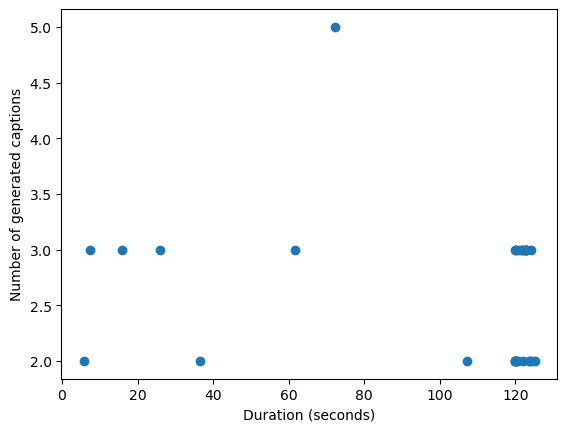

In [50]:
PLOT_SAVE_PATH = OUTPUT_PATH

x = ft_captions_bmt.duration
y = ft_captions_bmt.number_captions

plt.scatter(x, y)

plt.xlabel("Duration (seconds)")
plt.ylabel("Number of generated captions")


plt.savefig(f'{PLOT_SAVE_PATH}/3_4_a.png', dpi=300)
plt.show()

The plot shown above appears irregular because most videos have the same duration. Those samples that appear on the left hand side (smaller duration) were the remainings obtained from the end of each video. The other samples appear with a duration between 30 to 35 seconds. This happens because the BMT recalculates the duration based on a specific framerate used by the model. Hence, a video with an original framerate of 30 frames per second (fps) will be assigned a larger duration if the framerate used by BMT is 25 fps.

A histogram will help better visualize the results.

In [58]:
ft_captions_bmt.groupby("video_id")["number_captions"].sum().mean()

8.8

### 3.5 `pyscene` clipping
For this first test, we will be using a window of 2 minutes for performing the fixed-time clipping. Assign the variable `FT_CLIPS_DIR` the path to the directory where you wish to store the clips temporarily. 

In [59]:
PS_CLIPS_DIR = f'{OUTPUT_PATH}/ps_clips' # Your path here
%ls $PS_CLIPS_DIR

0kRtLFXIKpM@001.mp4  HzSkdZzqvT8@007.mp4  alF-r5DlERY@019.mp4
0kRtLFXIKpM@002.mp4  HzSkdZzqvT8@008.mp4  alF-r5DlERY@020.mp4
0kRtLFXIKpM@003.mp4  HzSkdZzqvT8@009.mp4  alF-r5DlERY@021.mp4
0kRtLFXIKpM@004.mp4  HzSkdZzqvT8@010.mp4  alF-r5DlERY@022.mp4
0kRtLFXIKpM@005.mp4  HzSkdZzqvT8@011.mp4  alF-r5DlERY@023.mp4
0kRtLFXIKpM@006.mp4  HzSkdZzqvT8@012.mp4  alF-r5DlERY@024.mp4
0kRtLFXIKpM@007.mp4  HzSkdZzqvT8@013.mp4  alF-r5DlERY@025.mp4
0kRtLFXIKpM@008.mp4  HzSkdZzqvT8@014.mp4  alF-r5DlERY@026.mp4
0kRtLFXIKpM@009.mp4  HzSkdZzqvT8@015.mp4  alF-r5DlERY@027.mp4
0kRtLFXIKpM@010.mp4  HzSkdZzqvT8@016.mp4  alF-r5DlERY@028.mp4
0kRtLFXIKpM@011.mp4  HzSkdZzqvT8@017.mp4  alF-r5DlERY@029.mp4
0kRtLFXIKpM@012.mp4  HzSkdZzqvT8@018.mp4  alF-r5DlERY@030.mp4
0kRtLFXIKpM@013.mp4  HzSkdZzqvT8@019.mp4  alF-r5DlERY@031.mp4
0kRtLFXIKpM@014.mp4  HzSkdZzqvT8@020.mp4  e4nrthWzflw@001.mp4
0kRtLFXIKpM@015.mp4  HzSkdZzqvT8@021.mp4  e4nrthWzflw@002.mp4
0kRtLFXIKpM@016.mp4  HzSkdZzqvT8@022.mp4  e4nrthWzflw@003.mp4
0kRtLFXI

The next cell instantiates the clipping module.

In [60]:
cm = ClippingModule(
    path_to_video_out=PS_CLIPS_DIR, 
    technique='scene'
)

We then obtain clips from all videos:

In [25]:
videos_list = os.listdir(MABC_VIDEOS_PATH)

for video in videos_list[:10]:
    if video[0] != '.': # ignore hidden files
        input_path = f'{MABC_VIDEOS_PATH}/{video}'
        # cm.get_clips(input_path=f'{MABC_VIDEOS_PATH}/{video}', name=video[:11])
        !scenedetect \
            -i $input_path \
            -o $PS_CLIPS_DIR \
            --min-scene-len 00:00:5.0 \
            --merge-last-scene \
            detect-content \
            split-video

[PySceneDetect] PySceneDetect v0.6.0.3
[PySceneDetect] Output directory set:
  /home/A01630791/bmt_clipping_experiments/Output_4_5/ps_clips/other
[PySceneDetect] ffmpeg arguments: -c:v libx264 -preset veryfast -crf 22 -c:a aac
[PySceneDetect] Detecting scenes...
[PySceneDetect] Downscale factor set to 5, effective resolution: 256 x 144
100%|██████████████████████████████████| 7615/7615 [00:15<00:00, 483.29frames/s]
[PySceneDetect] Processed 7615 frames in 15.8 seconds (average 482.94 FPS).
[PySceneDetect] Detected 32 scenes, average shot length 7.9 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:00:07.400,00:00:14.167,00:00:21.333,00:00:26.867,00:00:32.033,00:00:38.867,00:00:48.000,00:00:54.567,00:01:02.067,00:01:08.600,00:01:14.467,00:01:27.267,00:01:33.100,00:01:49.100,00:01:57.167,00:02:05.900,00:02:12.933,00:02:18.300,00:02:24.033,00:02:30.700,00:02:40.967,00:02:49.200,00:02:56.767,00:03:05.133,00:03:15.767,00:03:22.933,00:03:30.800,00:03:36.700,00:03:48.200,00:03:57.8

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/A01630791/bmt_clipping_experiments/MABC_videos/alF-r5DlERY.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    creation_time   : 2021-02-19T20:12:05.000000Z
  Duration: 00:04:59.72, start: 0.000000, bitrate: 1670 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(tv, bt709), 1280x720 [SAR 1:1 DAR 16:9], 1539 kb/s, 25 fps, 25 tbr, 12800 tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2021-02-19T20:12:05.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 02/19/2021.
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      creation_time   : 2021-02-19T20:12:05.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 02/19/2021.
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (aac (native) 

frame=  150 fps=132 q=-1.0 Lsize=    1523kB time=00:00:05.01 bitrate=2488.3kbits/s speed= 4.4x    
video:1436kB audio:81kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.427328%
[libx264 @ 0x5614ea4b02c0] frame I:1     Avg QP:22.50  size: 33336
[libx264 @ 0x5614ea4b02c0] frame P:75    Avg QP:22.00  size: 13695
[libx264 @ 0x5614ea4b02c0] frame B:74    Avg QP:24.90  size:  5537
[libx264 @ 0x5614ea4b02c0] consecutive B-frames: 20.7% 34.7% 18.0% 26.7%
[libx264 @ 0x5614ea4b02c0] mb I  I16..4: 16.1% 61.6% 22.2%
[libx264 @ 0x5614ea4b02c0] mb P  I16..4: 16.1% 25.8%  2.2%  P16..4: 17.4%  7.9%  3.2%  0.0%  0.0%    skip:27.3%
[libx264 @ 0x5614ea4b02c0] mb B  I16..4:  2.6%  9.9%  0.3%  B16..8: 12.4%  4.3%  0.6%  direct: 4.6%  skip:65.4%  L0:45.6% L1:45.8% BI: 8.7%
[libx264 @ 0x5614ea4b02c0] 8x8 transform intra:62.7% inter:41.2%
[libx264 @ 0x5614ea4b02c0] coded y,uvDC,uvAC intra: 40.7% 39.4% 5.3% inter: 6.8% 10.8% 2.3%
[libx264 @ 0x5614ea4b02c0] i16 v,h,dc,p: 50% 22% 10% 18%
[

[aac @ 0x561272167180] Qavg: 787.750
[PySceneDetect] Output from ffmpeg for Scene 1 shown above, splitting remaining scenes...
100%|█████████████████████████████████| 10313/10313 [01:21<00:00, 126.68frame/s]
[PySceneDetect] Average processing speed 126.68 frames/sec.
[PySceneDetect] Video splitting completed, individual scenes written to disk.
[PySceneDetect] PySceneDetect v0.6.0.3
[PySceneDetect] Output directory set:
  /home/A01630791/bmt_clipping_experiments/Output_4_5/ps_clips/other
[PySceneDetect] ffmpeg arguments: -c:v libx264 -preset veryfast -crf 22 -c:a aac
[PySceneDetect] Detecting scenes...
[PySceneDetect] Downscale factor set to 5, effective resolution: 256 x 144
100%|██████████████████████████████████| 9040/9040 [00:17<00:00, 505.80frames/s]
[PySceneDetect] Processed 9040 frames in 17.9 seconds (average 505.50 FPS).
[PySceneDetect] Detected 9 scenes, average shot length 40.2 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:00:08.120,00:00:14.480,00:01:04.920,00

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/A01630791/bmt_clipping_experiments/MABC_videos/A_aFIpDqRPw.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    creation_time   : 2021-11-17T14:53:46.000000Z
  Duration: 00:06:34.11, start: 0.000000, bitrate: 1978 kb/s
    Stream #0:0(und): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt709), 1280x720 [SAR 1:1 DAR 16:9], 1846 kb/s, 29.97 fps, 29.97 tbr, 30k tbn, 59.94 tbc (default)
    Metadata:
      creation_time   : 2021-11-17T14:53:46.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 11/17/2021.
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      creation_time   : 2021-11-17T14:53:46.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 11/17/2021.
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (aac (n

[libx264 @ 0x5599b59bff40] using SAR=1/1
[libx264 @ 0x5599b59bff40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x5599b59bff40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5599b59bff40] 264 - core 157 - H.264/MPEG-4 AVC codec - Copyleft 2003-2018 - http://www.videolan.org/x264.html - options: cabac=1 ref=1 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=2 psy=1 psy_rd=1.00:0.00 mixed_ref=0 me_range=16 chroma_me=1 trellis=0 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=0 threads=22 lookahead_threads=5 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=1 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=10 rc=crf mbtree=1 crf=22.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/A01630791/bmt_clipping_experiments/Output_4_5/ps_clips/other/aZPAKeZe_Vc-Scene-001.mp4':

frame=  816 fps=154 q=-1.0 Lsize=    9671kB time=00:00:27.21 bitrate=2911.1kbits/s speed=5.12x    
video:9213kB audio:428kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.309240%
[libx264 @ 0x55b7525a1b80] frame I:5     Avg QP:21.07  size: 77214
[libx264 @ 0x55b7525a1b80] frame P:254   Avg QP:23.93  size: 23290
[libx264 @ 0x55b7525a1b80] frame B:557   Avg QP:28.40  size:  5622
[libx264 @ 0x55b7525a1b80] consecutive B-frames:  5.6%  6.9%  9.6% 77.9%
[libx264 @ 0x55b7525a1b80] mb I  I16..4: 12.2% 34.8% 53.0%
[libx264 @ 0x55b7525a1b80] mb P  I16..4:  4.0%  9.0%  3.9%  P16..4: 32.1% 15.3% 12.3%  0.0%  0.0%    skip:23.3%
[libx264 @ 0x55b7525a1b80] mb B  I16..4:  0.3%  0.7%  0.2%  B16..8: 20.6%  6.8%  2.0%  direct: 3.9%  skip:65.4%  L0:35.9% L1:43.4% BI:20.7%
[libx264 @ 0x55b7525a1b80] 8x8 transform intra:52.4% inter:25.5%
[libx264 @ 0x55b7525a1b80] coded y,uvDC,uvAC intra: 59.1% 54.3% 13.8% inter: 11.0% 5.9% 0.2%
[libx264 @ 0x55b7525a1b80] i16 v,h,dc,p: 36% 41% 15%  8%

[aac @ 0x5577296ef380] Qavg: 1097.560
[PySceneDetect] Output from ffmpeg for Scene 1 shown above, splitting remaining scenes...
100%|█████████████████████████████████| 14779/14779 [01:35<00:00, 154.40frame/s]
[PySceneDetect] Average processing speed 154.40 frames/sec.
[PySceneDetect] Video splitting completed, individual scenes written to disk.
[PySceneDetect] PySceneDetect v0.6.0.3
[PySceneDetect] Output directory set:
  /home/A01630791/bmt_clipping_experiments/Output_4_5/ps_clips/other
[PySceneDetect] ffmpeg arguments: -c:v libx264 -preset veryfast -crf 22 -c:a aac
[PySceneDetect] Detecting scenes...
[PySceneDetect] Downscale factor set to 5, effective resolution: 256 x 144
100%|████████████████████████████████| 15159/15159 [00:32<00:00, 470.39frames/s]
[PySceneDetect] Processed 15159 frames in 32.2 seconds (average 470.30 FPS).
[PySceneDetect] Detected 67 scenes, average shot length 7.5 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:00:05.038,00:00:10.077,00:00:17.117,

In [ ]:
# !for f in *-Scene-*; do mv -i -- "$f" "${f//-Scene-/@}"; done

We need to create a DataFrame to keep track of all filenames, video IDs and clip IDs.

In [63]:
# Initialize
df = pd.DataFrame(os.listdir(PS_CLIPS_DIR), columns=['filename'])

# Clean
df.drop(df[df['filename'].str.startswith('.')].index, inplace=True)

# Obtain clip id
df['clip_id'] = [(int) (re.findall("(?<=@).*?(?=\.)", row['filename'])[0]) for index, row in df.iterrows()]

# Obtain video id
df['video_id'] = [(re.findall(".*?(?=\@)", row['filename'])[0]) for index, row in df.iterrows()]

df.video_id.unique()

array(['alF-r5DlERY', '69cpDT0rJNM', 'A_aFIpDqRPw', 'qy6dlGpC3Ns',
       '0kRtLFXIKpM', 'aZPAKeZe_Vc', 'HzSkdZzqvT8', 'e4nrthWzflw',
       'KI8WzyzQbGE', 'v4hRS2XF5WA'], dtype=object)

In [64]:
# optional: select fewer videos if time limitations
limited_sample_video_ids = df.video_id.unique()[:10]
limited_sample_video_ids

limited_df = df[df['video_id'].isin(limited_sample_video_ids)]
limited_df.head()

,filename,clip_id,video_id
0,alF-r5DlERY@001.mp4,1,alF-r5DlERY
1,69cpDT0rJNM@001.mp4,1,69cpDT0rJNM
2,A_aFIpDqRPw@044.mp4,44,A_aFIpDqRPw
3,A_aFIpDqRPw@019.mp4,19,A_aFIpDqRPw
4,A_aFIpDqRPw@001.mp4,1,A_aFIpDqRPw


The next cell will execute the BMT model to generate captions for each clip.

In [65]:
# execution metadata
exec_md = {
    'current_sample_num': 1,
    'total_samples': limited_df.shape[0],
}


for index, sample in limited_df.iterrows():
    
    run_bmt(
        input_path=f'{PS_CLIPS_DIR}/{sample.filename}', 
        output_path=f'{OUTPUT_PATH}/4_5_bmt_captions_ps.json', 
        video_id=sample.video_id, 
        clip_id=sample.clip_id
    )
    

    curr_sample = exec_md['current_sample_num']
    exec_md['current_sample_num'] += 1
    total_samples = exec_md['total_samples']
    print(f'\n ***** Processed {curr_sample}/{total_samples} samples. *****\n')


Video Duration: 6.144
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'alF-r5DlERY', 'clip_id': '1', 'captions': [{'start': 3.3, 'end': 4.8, 'sentence': "The person uses a brush to bru

Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.31s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.49s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  12
***** S *****:  5
***** S *****:  5
{'video_id': 'alF-r5DlERY', 'clip_id': '13', 'captions': [{'start': 0.2, 'end': 1.9, 'sentence': 'A person is seen sitting on a couch with a dog in a white dog'}, {'start': 

BMT Execution completed.

 ***** Processed 12/355 samples. *****

Video Duration: 6.557
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.60s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.21s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'HzSkdZzqvT8', 'clip_id': '10', 'captions': [{'s

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.98s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  9
***** S *****:  4
***** S *****:  4
{'video_id': 'alF-r5DlERY', 'clip_id': '11', 'captions': [{'start': 0.4, 'end': 1.9, 'sentence': 'He puts a towel on the sink'}, {'start': 5.9, 'end': 7.6, 'sentence': 'The person puts the towel on the towel'}, {'start': 3.2, 'end': 4.7, 'sentence': 'A woman is seen sitting on a bed with a towel'}], 'duration': 8.664}
BMT Execution completed.

 ***** Processed 18/355 samples. *****

Video Duration: 9.834
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.23s/it]
Extracting VGGish features.
Saving features to /home/A0163

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.61s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  12
***** S *****:  5
***** S *****:  5
{'video_id': 'alF-r5DlERY', 'clip_id': '23', 'captions': [{'start': 0.0, 'end': 1.8, 'sentence': 'The lady washes the dog with the towel'}, {'start': 6.3, 'end': 11.9, 'sentence': 'The man then takes the dog off his hands'}, {'start': 10.2, 'end': 11.8, 'sentence': 'The dog is shown again'}], 'duration': 11.864}
BMT Execution completed.

 ***** Processed 24/355 samples. *****

Video Duration: 6.79
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.05s/it]
Extracting VGGish features.
Saving features to /home/A01630791/B

Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '6', 'captions': [{'start': 5.5, 'end': 5.8, 'sentence': 'A girl in a blue shirt is talking to the camera'}, {'start': 4.7, 'end': 5.8, 'sentence': 'A woman in a blue shirt is talking to the camera'}, {'start': 0.4, 'end': 3.1, 'sentence': 'The girl walks away and walks away'}, {'start': 2.9, 'end': 4.4, 'sentence': 'The girl walks away and smiles'}], 'duration': 5.796}
BMT Execution completed.

 ***** Processed 30/355 samples. *****

Video Duration: 5.896
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.53s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Cl

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': '69cpDT0rJNM', 'clip_id': '6', 'captions': [{'start': 0.0, 'end': 0.9, 'sentence': 'A man is seen standing on a floor with a man in his hands'}, {'start': 0.0, 'end': 3.4, 'sentence': 'A man in a black shirt is standing on a diving board'}, {'start': 4.7, 'end': 5.8, 'sentence': 'A man in a blue shirt is standing on a floor'}], 'duration': 5.763}
BMT Execution completed.

 ***** Processed 36/355 samples. *****

Video Duration: 6.597
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.36s/it]
Extracting VGGis

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'A_aFIpDqRPw', 'clip_id': '5', 'captions': [{'start': 5.1, 'end': 6.7, 'sentence': 'A man is talking in a room'}, {'start': 6.2, 'end': 7.1, 'sentence': 'A man is talking in a room'}, {'start': 0.1, 'end': 2.4, 'sentence': 'A man in a black shirt is talking to the camera'}, {'start': 5.9, 'end': 6.4, 'sentence': 'A man is talking in a room'}, {'start': 1.5, 'end': 7.1, 'sentence': 'A man is talking in a room'}], 'duration': 7.097}
BMT Execution completed.

 ***** Processed 42/355 samples. *****

Video Duration: 8.39
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|███████

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.76s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '58', 'captions': [{'start': 0.7, 'end': 6.0, 'sentence': 'The woman then grabs a blue ball and puts it down'}, {'start': 0.4, 'end': 2.5, 'sentence': 'A woman is seen sitting on a couch with a baby in her hand'}, {'start': 1.4, 'end': 3.5, 'sentence': 'A woman is seen sitting on a couch with a baby in her hand'}], 'duration': 6.03}
BMT Execution completed.

 ***** Processed 48/355 samples. *****

Video Duration: 5.924
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]
Extr

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.79s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  3
***** S *****:  3
{'video_id': 'HzSkdZzqvT8', 'clip_id': '27', 'captions': [{'start': 0.3, 'end': 2.2, 'sentence': 'A man is talking to the camera'}, {'start': 5.7, 'end': 7.6, 'sentence': 'A man is talking to the camera'}, {'start': 3.1, 'end': 4.8, 'sentence': 'A man is seen speaking to the camera while holding a bottle of water'}, {'start': 4.9, 'end': 6.5, 'sentence': 'A man is seen speaking to the camera while holding a bottle of water'}], 'duration': 7.89}
BMT Execution completed.

 ***** Processed 54/355 samples. *****

Video Duration: 6.73
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|██████

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'HzSkdZzqvT8', 'clip_id': '3', 'captions': [{'start': 5.1, 'end': 7.2, 'sentence': 'A man is seen standing on a wooden table with a long stick'}, {'start': 0.1, 'end': 6.2, 'sentence': 'The man shoots the arrow'}, {'start': 0.1, 'end': 1.8, 'sentence': 'The man stops and shows the camera'}], 'duration': 7.19}
BMT Execution completed.

 ***** Processed 60/355 samples. *****

Video Duration: 6.931
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]
Extracting VGGish features.
Saving features to /home/A

***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'e4nrthWzflw', 'clip_id': '1', 'captions': [{'start': 0.5, 'end': 2.1, 'sentence': 'A person is seen standing on a counter with a large child standing on a large child in a large bowl'}, {'start': 2.9, 'end': 4.6, 'sentence': 'A woman is seen sitting in a kitchen with a camera holding a large child in her hands'}], 'duration': 5.062}
BMT Execution completed.

 ***** Processed 66/355 samples. *****

Video Duration: 7.398
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.95s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|████████████████████████████

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': '0kRtLFXIKpM', 'clip_id': '22', 'captions': [{'start': 5.2, 'end': 5.9, 'sentence': 'She puts the shoe on the shoe'}, {'start': 1.5, 'end': 5.9, 'sentence': 'The person puts a shoe on the shoe and puts it on'}, {'start': 0.5, 'end': 2.2, 'sentence': 'A person is seen sitting on a chair with a shoe and then puts it on the shoe on the shoe'}, {'start': 2.7, 'end': 3.9, 'sentence': 'A person puts a shoe on the shoe and puts a shoe on'}], 'duration': 5.863}
BMT Execution completed.

 ***** Processed 72/355 samples. *****

Video Duration: 10.835
Extracting I3D features.
Saving features to /home/A01630791/BMT-C

Video Duration: 5.557
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.38s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'HzSkdZzqvT8', 'clip_id': '4', 'captions': [{'start': 2.5, 'end': 4.1, 'sentence': 'A man in a black shirt is talk

{'video_id': '0kRtLFXIKpM', 'clip_id': '11', 'captions': [{'start': 0.0, 'end': 1.5, 'sentence': 'A person is seen holding a brush and rubbing a towel'}, {'start': 1.9, 'end': 4.1, 'sentence': 'The person puts a towel on the towel and wipes it with a towel'}, {'start': 0.8, 'end': 1.6, 'sentence': 'A person is seen holding a brush and rubbing a towel'}, {'start': 3.4, 'end': 4.2, 'sentence': 'The person puts a towel on the shoe'}], 'duration': 5.563}
BMT Execution completed.

 ***** Processed 83/355 samples. *****

Video Duration: 16.024
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.21s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, ple

Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'HzSkdZzqvT8', 'clip_id': '18', 'captions': [{'start': 0.5, 'end': 5.4, 'sentence': 'A man is seen standing on a bike holding a bow'}, {'start': 3.0, 'end': 4.3, 'sentence': 'A man is standing on a bike'}, {'start': 0.3, 'end': 2.0, 'sentence': 'A man is seen holding a bow and holding a bow'}], 'duration': 5.39}
BMT Execution completed.

 ***** Processed 89/355 samples. *****

Video Duration: 6.997
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed ther

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.73s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.63s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  3
***** S *****:  3
{'video_id': '69cpDT0rJNM', 'clip_id': '4', 'captions': [{'start': 6.3, 'end': 7.9, 'sentence': 'A young girl is seen standing on a mat with a young girl standing in her hand'}, {'start': 0.4, 'end': 7.9, 'sentence': 'A man is 

Video Duration: 5.095
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.66s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
Traceback (most recent call last):
  File "./sample/single_video_prediction.py", line 317, in <module>
    cap_model, feature_p

BMT Execution completed.

 ***** Processed 106/355 samples. *****

Video Duration: 7.531
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.71s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '53', 'captions': [{'

BMT Execution completed.

 ***** Processed 112/355 samples. *****

Video Duration: 7.031
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '12', 'captions': [{'

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.58s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.71s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'HzSkdZzqvT8', 'clip_id': '13', 'captions': [{'start': 0.7, 'end': 2.4, 'sentence': 'A man is seen sitting on a couch'}, {'start': 5.1, 'end': 5.9, 'sentence': 'A man is seen standing on a ladder and speaking to th

BMT Execution completed.

 ***** Processed 124/355 samples. *****

Video Duration: 5.462
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'A_aFIpDqRPw', 'clip_id': '7', 'captions': [{'s

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'A_aFIpDqRPw', 'clip_id': '29', 'captions': [{'start': 0.0, 'end': 3.0, 'sentence': 'A man is seen sitting on a chair and begins to talk'}, {'start': 5.0, 'end': 7.4, 'sentence': 'The man in black shirt walks away'}, {'start': 5.9, 'end': 6.3, 'sentence': 'A man in a black shirt walks up to the man in the room'}], 'duration': 7.398}
BMT Execution completed.

 ***** Processed 131/355 samples. *****

Video Duration: 7.064
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]
Extracting VGGish features.
S

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': '69cpDT0rJNM', 'clip_id': '3', 'captions': [{'start': 0.0, 'end': 6.6, 'sentence': 'The man then begins to do a bow'}, {'start': 0.0, 'end': 1.8, 'sentence': 'He is holding a stick'}, {'start': 5.3, 'end': 7.2, 'sentence': 'The girl then does a flip and does a flip'}], 'duration': 7.464}
BMT Execution completed.

 ***** Processed 137/355 samples. *****

Video Duration: 5.162
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping

BMT Execution completed.

 ***** Processed 143/355 samples. *****

Video Duration: 8.332
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  4
***** S *****:  4
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '44', 'captions': [{'

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'alF-r5DlERY', 'clip_id': '29', 'captions': [{'start': 0.0, 'end': 1.6, 'sentence': 'The man puts the dog down'}, {'start': 0.8, 'end': 2.5, 'sentence': 'The man puts the dog down'}, {'start': 5.3, 'end': 6.2, 'sentence': 'A woman is seen sitting on a chair with a dog in a tub'}, {'start': 3.4, 'end': 5.3, 'sentence': 'The man then cleans the dog with a towel'}], 'duration': 6.184}
BMT Execution completed.

 ***** Processed 149/355 samples. *****

Video Duration: 7.865
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:

BMT Execution completed.

 ***** Processed 154/355 samples. *****

Video Duration: 5.529
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.78s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.81s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'e4nrthWzflw', 'clip_id': '10', 'captions': [{'

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': '0kRtLFXIKpM', 'clip_id': '21', 'captions': [{'start': 0.2, 'end': 1.3, 'sentence': 'The person puts the shoe on the shoe and puts it on'}, {'start': 2.9, 'end': 3.9, 'sentence': 'The person puts a shoe on the shoe

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'A_aFIpDqRPw', 'clip_id': '17', 'captions': [{'start': 0.2, 'end': 2.1, 'sentence': 'The man in the black shirt walks away'}, {'start': 1.3, 'end': 5.0, 'sentence': 'The man in the black shirt walks away'}, {'start

BMT Execution completed.

 ***** Processed 174/355 samples. *****

Video Duration: 6.497
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': '69cpDT0rJNM', 'clip_id': '24', 'captions': [{'

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.75s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'HzSkdZzqvT8', 'clip_id': '17', 'captions': [{'start': 5.5, 'end': 7.1, 'sentence': 'A man in a black shirt is talking to the camera'}, {'start': 3.0, 'end': 4.8, 'sentence': 'A man in a black shirt is talking to t

Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.27s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  16
***** S *****:  6
***** S *****:  6
{'video_id': '0kRtLFXIKpM', 'clip_id': '9', 'captions': [{'start': 0.0, 'end': 1.8, 'sentence': 'The person puts a pair of shoes on the bed'}, {'start': 0.7, 'end': 5.3, 'se

Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  3
***** S *****:  3
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '4', 'captions': [{'start': 0.0, 'end': 1.7, 'sentence': 'A girl does a flip'}, {'start': 2.5, 'end': 4.3, 'sentence': 'The girl does a

BMT Execution completed.

 ***** Processed 198/355 samples. *****

Video Duration: 7.598
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'A_aFIpDqRPw', 'clip_id': '24', 'captions': [{'

Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  35
***** S *****:  13
***** S *****:  13
{'video_id': '0kRtLFXIKpM', 'clip_id': '1', 'captions': [{'start': 0.1, 'end': 1.8, 'sentence': "A person is seen sitting on a chair with a shoe on it 's hand"}, {'start': 3.9, 'end': 30.4, 'sentence': 'The person puts the shoe in the shoe and puts the shoe down'}, {'start': 0.3, 'end': 5.0, 'sentence': 'A person is seen sitting on a table with a white cloth and a white cloth'}], 'duration': 33.757}
BMT Execution completed.

 ***** Processed 204/355 samples. *****

Video Duration: 11.602
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.76s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * ht

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  13
***** S *****:  5
***** S *****:  5
{'video_id': 'v4hRS2XF5WA', 'clip_id': '19', 'captions': [{'start': 0.0, 'end': 2.1, 'sentence': 'The man in the blue shirt walks away'}, {'start': 10.9, 'end': 12.4, 'sentence': 'The man in the black shirt is playing a game of the game'}, {'start': 7.1, 'end': 13.1, 'sentence': 'The man in the black shirt walks away and we see the crowd'}], 'duration': 13.124}
BMT Execution completed.

 ***** Processed 210/355 samples. *****

Video Duration: 18.042
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.03s/it]
Extracting 

BMT Execution completed.

 ***** Processed 217/355 samples. *****

Video Duration: 5.864
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.41s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'alF-r5DlERY', 'clip_id': '12', 'captions': [{'

BMT Execution completed.

 ***** Processed 223/355 samples. *****

Video Duration: 5.062
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'e4nrthWzflw', 'clip_id': '2', 'captions': [{'s

BMT Execution completed.

 ***** Processed 229/355 samples. *****

Video Duration: 5.129
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  3
***** S *****:  3
{'video_id': 'A_aFIpDqRPw', 'clip_id': '28', 'captions': [{'

BMT Execution completed.

 ***** Processed 235/355 samples. *****

Video Duration: 5.83
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'aZPAKeZe_Vc', 'clip_id': '35', 'captions': [{'s

BMT Execution completed.

 ***** Processed 241/355 samples. *****

Video Duration: 6.897
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.68s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'e4nrthWzflw', 'clip_id': '59', 'captions': [{'

Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'alF-r5DlERY', 'clip_id': '21', 'captions': [{'start': 3.4, 'end': 4.6, 'sentence': 'A woman is sitting on a couch with a dog in her hand'}, {'start': 0.7, 'end'

Video Duration: 13.704
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.53s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  14
***** S *****:  6
***** S *****:  6
{'video_id': 'alF-r5DlERY', 'clip_id': '27', 'captions': [{'start': 0.7, 'end': 2.3, 'sentence': 'The man washes his face wit

BMT Execution completed.

 ***** Processed 259/355 samples. *****

Video Duration: 7.464
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.89s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'e4nrthWzflw', 'clip_id': '14', 'captions': [{'

BMT Execution completed.

 ***** Processed 265/355 samples. *****

Video Duration: 16.384
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.01s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  17
***** S *****:  7
***** S *****:  7
Traceback (most recent call last):
  File "./sample/single

BMT Execution completed.

 ***** Processed 271/355 samples. *****

Video Duration: 8.365
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  4
***** S *****:  4
{'video_id': 'e4nrthWzflw', 'clip_id': '5', 'captions': [{'s

BMT Execution completed.

 ***** Processed 277/355 samples. *****

Video Duration: 5.062
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.82s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'A_aFIpDqRPw', 'clip_id': '38', 'captions': [{'

BMT Execution completed.

 ***** Processed 283/355 samples. *****

Video Duration: 27.624
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.72s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.15s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  28
***** S *****:  11
***** S *****:  11
{'video_id': 'v4hRS2XF5WA', 'clip_id': '21', 'captions':

BMT Execution completed.

 ***** Processed 289/355 samples. *****

Video Duration: 5.062
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': 'A_aFIpDqRPw', 'clip_id': '16', 'captions': [{'

***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'e4nrthWzflw', 'clip_id': '56', 'captions': [{'start': 5.7, 'end': 6.2, 'sentence': 'The camera pans around the water'}, {'start': 0.5, 'end': 1.8, 'sentence': 'A person is seen sitting on a rock'}, {'start': 0.8, 'end': 6.2, 'sentence': 'The person uses a tool to blow the leaves'}, {'start': 0.0, 'end': 0.8, 'sentence': 'A person is seen sitting on a rock'}, {'start': 3.3, 'end': 4.7, 'sentence': 'The camera pans around the area of the roof'}], 'duration': 6.23}
BMT Execution completed.

 ***** Processed 295/355 samples. *****

Video Duration: 7.231
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://g

Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  18
***** S *****:  8
***** S *****:  8
{'video_id': 'v4hRS2XF5WA', 'clip_id': '27', 'captions': [{'start': 0.0, 'end': 2.3, 'sentence': 'The man in the red shirt runs and throws the javelin'}, {'start': 2.8, 'end': 13.8, 'sentence': 'The man in the black shirt walks away and we see the camera'}, {'start': 14.2, 'end': 18.0, 'sentence': 'The man in the black shirt walks away'}, {'start': 0.7, 'end': 6.1, 'sentence': 'The man in blue shirt is standing on the court'}, {'start': 16.8, 'end': 18.0, 'sentence': 'The man in the black shirt walks away'}], 'duration': 17.99}
BMT Execution completed.

 ***** Processed 301/355 samples. *****

Video Duration: 8.566
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.69s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.71s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'e4nrthWzflw', 'clip_id': '62', 'captions': [{'start': 1.2, 'end': 5.7, 'sentence': 'The person adds a large bowl to the pasta'}, {'start': 0.0, 'end': 2.2, 'sentence': 'A person is seen standing in a kitchen with a large bowl of pasta and mixing it into a bowl'}], 'duration': 6.163}
BMT Execution completed.

 ***** Processed 307/355 samples. *****

Video Duration: 8.532
Ex

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  28
***** S *****:  11
***** S *****:  11
{'video_id': 'v4hRS2XF5WA', 'clip_id': '22', 'captions': [{'start': 0.0, 'end': 26.9, 'sentence': 'A group of people are seen running around a court and throwing a basketball ball around'}, {'start': 0.0, 'end': 2.4, 'sentence': 'The man in blue shirt is running down the court'}], 'duration': 26.924}
BMT Execution completed.

 ***** Processed 313/355 samples. *****

Video Duration: 20.89
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.47s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipp

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  5
***** S *****:  2
***** S *****:  2
{'video_id': '0kRtLFXIKpM', 'clip_id': '4', 'captions': [{'start': 0.0, 'end': 1.5, 'sentence': 'A person is seen putting a shoe on a towel and rubbing it off'}, {'start': 2.3, 'end': 4.0, 'sentence': 'He then puts a towel on a towel'}], 'duration': 5.029}
BMT Execution completed.

 ***** Processed 319/355 samples. *****

Video Duration: 5.563
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * 

Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  33
***** S *****:  13
***** S *****:  13
{'video_id': '69cpDT0rJNM', 'clip_id': '14', 'captions': [{'start': 7.4, 'end': 30.8, 'sentence': 'A man in a blue shirt is standing in front of a large gym'}, {'start': 27.9, 'end': 31.1, 'sentence': 'A man in a black shirt is standing in a room talking'}], 'duration': 31.856}
BMT Execution completed.

 ***** Processed 325/355 samples. *****

Video Duration: 9.733
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.75s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.81s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  7
***** S *****:  3
***** S *****:  3
{'video_id': 'A_aFIpDqRPw', 'clip_id': '10', 'captions': [{'start': 0.3, 'end': 1.9, 'sentence': 'A man in a black shirt is standing in a gym'}, {'start': 0.0, 'end': 5.0, 'sentence': 'The man in the black shirt is standing on the floor'}, {'start': 5.7, 'end': 6.0, 'sentence': 'A man in a white shirt is standing in front of a large crowd'}, {'start': 5.6, 'end': 7.2, 'sentence': 'A man in a white shirt is standing in front of a large crowd'}, {'start': 0.3, 'end': 0.5, 'sentence': 'A man in a black shirt is standing in a gym'}], 'duration': 7.264}
BMT Execution completed.

 ***** Processed 331/355 samples. *****

Vid

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  3
***** S *****:  3
{'video_id': 'e4nrthWzflw', 'clip_id': '43', 'captions': [{'start': 0.2, 'end': 3.2, 'sentence': 'A man is standing in a kitchen'}, {'start': 4.7, 'end': 7.9, 'sentence': 'The man puts a white plate in the pot'}, {'start': 2.1, 'end': 5.4, 'sentence': 'A man is standing in a kitchen talking to the camera'}], 'duration': 8.232}
BMT Execution completed.

 ***** Processed 337/355 samples. *****

Video Duration: 5.262
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]
Extracting VGGish features.
Saving features to /

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  8
***** S *****:  3
***** S *****:  3
{'video_id': 'qy6dlGpC3Ns', 'clip_id': '1', 'captions': [{'start': 5.5, 'end': 7.2, 'sentence': 'A woman in a black shirt is standing in front of a woman'}, {'start': 0.0, 'end': 1.8, 'sentence': 'A woman is standing in a room with a white words on the screen'}, {'start': 2.4, 'end': 5.1, 'sentence': 'A woman is seen standing in a room with a woman standing in a large room'}], 'duration': 8.144}
BMT Execution completed.

 ***** Processed 343/355 samples. *****

Video Duration: 5.304
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00

Video Duration: 9.557
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.80s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  9
***** S *****:  4
***** S *****:  4
{'video_id': 'v4hRS2XF5WA', 'clip_id': '8', 'captions': [{'start': 7.8, 'end': 9.6, 'sentence': 'The man in the black shirt run

BMT Execution completed.

 ***** Processed 354/355 samples. *****

Video Duration: 6.39
Extracting I3D features.
Saving features to /home/A01630791/BMT-Clipping/tmp/
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]
Extracting VGGish features.
Saving features to /home/A01630791/BMT-Clipping/tmp/

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]
Generating caption...
Contructing caption_iterator for "train" phase
Using vanilla Generator
initialization: xavier
Glove emb of the same size as d_model_caps
Pretrained caption path: 
 /home/A01630791/BMT-Clipping/sample/best_cap_model.pt
***** S *****:  6
***** S *****:  3
***** S *****:  3
{'video_id': 'v4hRS2XF5WA', 'clip_id': '18', 'captions': [{'s

In [66]:
# (Optional) Secure the file with a copy to prevent rewriting
!cp $OUTPUT_PATH/4_5_bmt_captions_ps.json $OUTPUT_PATH/4_5_bmt_captions_ps_save.json

**Analyzing pyscene clipping results**

The next cell will create a dataframe using the output from BMT

In [67]:
path_to_ps_results = f'{OUTPUT_PATH}/4_5_bmt_captions_ps_save.json'

ps_captions_bmt = pd.read_json(path_to_ps_results, orient='records')
# ft_captions_bmt.sort_values(by="clip_id", inplace=True)

In [68]:
# Add the number of captions column
ps_captions_bmt['number_captions'] = [len(sample.captions) for _, sample in ps_captions_bmt.iterrows()]
ps_captions_bmt.head()

,captions,clip_id,duration,video_id,number_captions
0,"[{'start': 3.3, 'end': 4.8, 'sentence': 'The p...",1,6.144,alF-r5DlERY,3
1,"[{'start': 0.5, 'end': 8.1, 'sentence': 'The l...",1,8.532,69cpDT0rJNM,3
2,"[{'start': 0.1, 'end': 2.9, 'sentence': 'We se...",44,5.429,A_aFIpDqRPw,4
3,"[{'start': 0.1, 'end': 2.3, 'sentence': 'A man...",19,9.600,A_aFIpDqRPw,2
4,"[{'start': 0.1, 'end': 3.1, 'sentence': 'We se...",1,8.866,A_aFIpDqRPw,3


Average number of generated captions:

In [69]:
ps_captions_bmt.number_captions.mean()

3.2166172106824926

Average captions per minute

In [70]:
ps_captions_bmt['CPM'] = [sample.number_captions / (sample.duration / 60) for _, sample in ps_captions_bmt.iterrows()]
ps_captions_bmt.CPM.mean()

24.50221895449777

Plot number of captions 

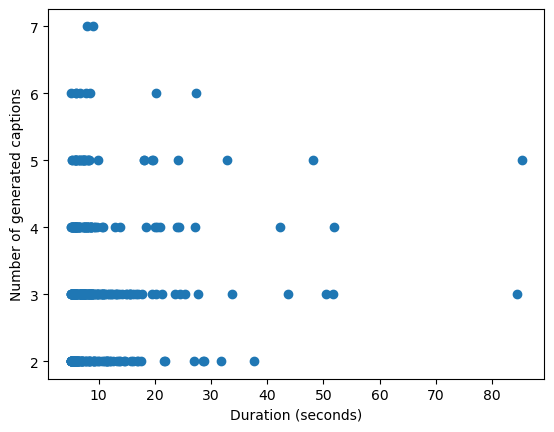

In [71]:
PLOT_SAVE_PATH = OUTPUT_PATH

x = ps_captions_bmt.duration
y = ps_captions_bmt.number_captions

plt.scatter(x, y)

plt.xlabel("Duration (seconds)")
plt.ylabel("Number of generated captions")


plt.savefig(f'{PLOT_SAVE_PATH}/3_4_a.png', dpi=300)
plt.show()

The plot shown above appears irregular because most videos have the same duration. Those samples that appear on the left hand side (smaller duration) were the remainings obtained from the end of each video. The other samples appear with a duration between 30 to 35 seconds. This happens because the BMT recalculates the duration based on a specific framerate used by the model. Hence, a video with an original framerate of 30 frames per second (fps) will be assigned a larger duration if the framerate used by BMT is 25 fps.

A histogram will help better visualize the results.

In [73]:
ps_captions_bmt.groupby("video_id")["number_captions"].sum().mean()

108.4

In [74]:
ps_captions_bmt.groupby(by="video_id").number_captions.sum()

video_id
0kRtLFXIKpM    114
69cpDT0rJNM     88
A_aFIpDqRPw    160
HzSkdZzqvT8    108
KI8WzyzQbGE     27
aZPAKeZe_Vc    203
alF-r5DlERY     85
e4nrthWzflw    179
qy6dlGpC3Ns     30
v4hRS2XF5WA     90
Name: number_captions, dtype: int64

**Comparisons with histograms.**

In [ ]:
anetc_val_path = '/home/A01630791/bmt_clipping_experiments/ActivityNet_Captions/val_1.json'
anetc_val_df = pd.read_json(anetc_val_path, orient='index')

bmt_results_path = '/home/A01630791/bmt_clipping_experiments/Output_4_1/4_1_bmt_captions_save.json'
bmt_results_df = pd.read_json(bmt_results_path, orient='records')

In [ ]:
# compute no. captions
anetc_val_df['number_captions'] = [len(sample.sentences) for index, sample in anetc_val_df.iterrows()]

bmt_results_df['number_captions'] = [len(sample.captions) for index, sample in bmt_results_df.iterrows()]
bmt_results_df.head()

In [ ]:
# graphs
anetc_val_df.number_captions.plot.hist()

In [ ]:
bmt_results_df.number_captions.plot.hist()

In [ ]:
dpi_fig = plt.figure(dpi=300)

anetc_val_df.iloc[:].number_captions.plot.hist(color="lightblue")
ax = ft_captions_bmt.number_captions.plot.hist()
ax.legend(['ActivityNet (Annotations)', 'LABC (BMT-generated)'])
ax.set_xlabel('Number of captions')


In [ ]:
fig = ax.get_figure()
fig.savefig(f'{PLOT_SAVE_PATH}/3_4_b.png', dpi=300)

The histogram shown above with number of captions against frequency displays the similarity between the distrbution of human annotations the model was trained on and the distribution of the number of captions generated by the BMT with a different dataset. 